In [1]:
#Final code of the project to detect damaged tissues on the lung

In [123]:
#importing libraries as needed
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import os
import os.path
from pathlib import Path
import glob
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import warnings
warnings.filterwarnings('ignore')
from PIL import Image 
from PIL.ImageDraw import Draw

In [124]:
#read in csv files
csv_path = 'csv_files/'
df_image_id = pd.read_csv(csv_path + 'nih-cxr-lt_image_ids.csv')
df_label_train = pd.read_csv(csv_path + 'nih-cxr-lt_single-label_train.csv')
df_label_test = pd.read_csv(csv_path + 'nih-cxr-lt_single-label_test.csv')
df_balanced_test = pd.read_csv(csv_path + 'nih-cxr-lt_single-label_balanced-test.csv')
df_balanced_val = pd.read_csv(csv_path + 'nih-cxr-lt_single-label_balanced-val.csv')
#there are 5 files:
#all image ids
#balanced testing dataset
#balanced validation dataset
#normal testing dataset
#normal training dataset

#fixing naming convention of a columns
df_label_train.rename(columns = {'No Finding':'No_Finding'}, inplace = True)
df_label_train.rename(columns = {'Subcutaneous Emphysema':'Subcutaneous_Emphysema'}, inplace = True)
df_label_train.rename(columns = {'Tortuous Aorta':'Tortuous_Aorta'}, inplace = True)
df_label_train.rename(columns = {'Calcification of the Aorta':'Calcification_of_the_Aorta'}, inplace = True)
df_label_test.rename(columns = {'No Finding':'No_Finding'}, inplace = True)
df_label_test.rename(columns = {'Subcutaneous Emphysema':'Subcutaneous_Emphysema'}, inplace = True)
df_label_test.rename(columns = {'Tortuous Aorta':'Tortuous_Aorta'}, inplace = True)
df_label_test.rename(columns = {'Calcification of the Aorta':'Calcification_of_the_Aorta'}, inplace = True)
df_balanced_test.rename(columns = {'No Finding':'No_Finding'}, inplace = True)
df_balanced_test.rename(columns = {'Subcutaneous Emphysema':'Subcutaneous_Emphysema'}, inplace = True)
df_balanced_test.rename(columns = {'Tortuous Aorta':'Tortuous_Aorta'}, inplace = True)
df_balanced_test.rename(columns = {'Calcification of the Aorta':'Calcification_of_the_Aorta'}, inplace = True)
df_balanced_val.rename(columns = {'No Finding':'No_Finding'}, inplace = True)
df_balanced_val.rename(columns = {'Subcutaneous Emphysema':'Subcutaneous_Emphysema'}, inplace = True)
df_balanced_val.rename(columns = {'Tortuous Aorta':'Tortuous_Aorta'}, inplace = True)
df_balanced_val.rename(columns = {'Calcification of the Aorta':'Calcification_of_the_Aorta'}, inplace = True)

#create new dataframes that contain solely heart issues
#include columns only with heart related labels
#remove rows where all values are zero (no finding == 0 -> condition)
#cant do one liner for dropping so have to use conditional drop
df_label_train_heart = df_label_train[["id", "Cardiomegaly", "Infiltration", "Mass", "Nodule", "Tortuous_Aorta", "Calcification_of_the_Aorta", "No_Finding", "subject_id"]]
df_label_train_heart = df_label_train_heart.drop(df_label_train_heart[(df_label_train_heart.Cardiomegaly == 0) & (df_label_train_heart.Infiltration == 0) & (df_label_train_heart.Mass == 0) & (df_label_train_heart.Nodule == 0) & (df_label_train_heart.Tortuous_Aorta == 0) & (df_label_train_heart.Calcification_of_the_Aorta == 0) & (df_label_train_heart.No_Finding == 0) ].index)
df_label_test_heart = df_label_test[["id", "Cardiomegaly", "Infiltration", "Mass", "Nodule", "Tortuous_Aorta", "Calcification_of_the_Aorta", "No_Finding", "subject_id"]]
df_label_test_heart = df_label_test_heart.drop(df_label_test_heart[(df_label_test_heart.Cardiomegaly == 0) & (df_label_test_heart.Infiltration == 0) & (df_label_test_heart.Mass == 0) & (df_label_test_heart.Nodule == 0) & (df_label_test_heart.Tortuous_Aorta == 0) & (df_label_test_heart.Calcification_of_the_Aorta == 0) & (df_label_test_heart.No_Finding == 0) ].index)
df_balanced_test_heart = df_balanced_test[["id", "Cardiomegaly", "Infiltration", "Mass", "Nodule", "Tortuous_Aorta", "Calcification_of_the_Aorta", "No_Finding", "subject_id"]]
df_balanced_test_heart = df_balanced_test_heart.drop(df_balanced_test_heart[(df_balanced_test_heart.Cardiomegaly == 0) & (df_balanced_test_heart.Infiltration == 0) & (df_balanced_test_heart.Mass == 0) & (df_balanced_test_heart.Nodule == 0) & (df_balanced_test_heart.Tortuous_Aorta == 0) & (df_balanced_test_heart.Calcification_of_the_Aorta == 0) & (df_balanced_test_heart.No_Finding == 0) ].index)
df_balanced_val_heart = df_balanced_val[["id", "Cardiomegaly", "Infiltration", "Mass", "Nodule", "Tortuous_Aorta", "Calcification_of_the_Aorta", "No_Finding", "subject_id"]]
df_balanced_val_heart = df_balanced_val_heart.drop(df_balanced_val_heart[(df_balanced_val_heart.Cardiomegaly == 0) & (df_balanced_val_heart.Infiltration == 0) & (df_balanced_val_heart.Mass == 0) & (df_balanced_val_heart.Nodule == 0) & (df_balanced_val_heart.Tortuous_Aorta == 0) & (df_balanced_val_heart.Calcification_of_the_Aorta == 0) & (df_balanced_val_heart.No_Finding == 0) ].index)
display(df_label_train_heart)

# #create new dataframes that contain solely lung issues (what we are currently concerned with)
# #include columns only with lung related labels
# #remove rows where all values are zero
df_label_train_lung = df_label_train[["id", "Atelectasis", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", "Hernia", "Infiltration", "Mass", "Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax", "Pneumomediastinum", "No_Finding", "subject_id"]]
df_label_train_lung = df_label_train_lung.drop(df_label_train_lung[(df_label_train_lung.Atelectasis == 0) & (df_label_train_lung.Consolidation == 0) & (df_label_train_lung.Edema == 0) & (df_label_train_lung.Effusion == 0) & (df_label_train_lung.Emphysema == 0) & (df_label_train_lung.Fibrosis == 0) & (df_label_train_lung.Hernia == 0) & (df_label_train_lung.Infiltration == 0) & (df_label_train_lung.Mass == 0) & (df_label_train_lung.Nodule == 0) & (df_label_train_lung.Pleural_Thickening == 0) & (df_label_train_lung.Pneumonia == 0) & (df_label_train_lung.Pneumothorax == 0)& (df_label_train_lung.Pneumomediastinum == 0) & (df_label_train_lung.No_Finding == 0)].index)
df_label_test_lung = df_label_test[["id", "Atelectasis", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", "Hernia", "Infiltration", "Mass", "Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax", "Pneumomediastinum", "No_Finding", "subject_id"]]
df_label_test_lung = df_label_test_lung.drop(df_label_test_lung[(df_label_test_lung.Atelectasis == 0) & (df_label_test_lung.Consolidation == 0) & (df_label_test_lung.Edema == 0) & (df_label_test_lung.Effusion == 0) & (df_label_test_lung.Emphysema == 0) & (df_label_test_lung.Fibrosis == 0) & (df_label_test_lung.Hernia == 0) & (df_label_test_lung.Infiltration == 0) & (df_label_test_lung.Mass == 0) & (df_label_test_lung.Nodule == 0) & (df_label_test_lung.Pleural_Thickening == 0) & (df_label_test_lung.Pneumonia == 0) & (df_label_test_lung.Pneumothorax == 0)& (df_label_test_lung.Pneumomediastinum == 0) & (df_label_test_lung.No_Finding == 0)].index)
df_balanced_test_lung = df_balanced_test[["id", "Atelectasis", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", "Hernia", "Infiltration", "Mass", "Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax", "Pneumomediastinum", "No_Finding", "subject_id"]]
df_balanced_test_lung = df_balanced_test_lung.drop(df_balanced_test_lung[(df_balanced_test_lung.Atelectasis == 0) & (df_balanced_test_lung.Consolidation == 0) & (df_balanced_test_lung.Edema == 0) & (df_balanced_test_lung.Effusion == 0) & (df_balanced_test_lung.Emphysema == 0) & (df_balanced_test_lung.Fibrosis == 0) & (df_balanced_test_lung.Hernia == 0) & (df_balanced_test_lung.Infiltration == 0) & (df_balanced_test_lung.Mass == 0) & (df_balanced_test_lung.Nodule == 0) & (df_balanced_test_lung.Pleural_Thickening == 0) & (df_balanced_test_lung.Pneumonia == 0) & (df_balanced_test_lung.Pneumothorax == 0) & (df_balanced_test_lung.Pneumomediastinum == 0) & (df_balanced_test_lung.No_Finding == 0)].index)
df_balanced_val_lung = df_balanced_val[["id", "Atelectasis", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", "Hernia", "Infiltration", "Mass", "Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax", "Pneumomediastinum", "No_Finding", "subject_id"]]
df_balanced_val_lung = df_balanced_val_lung.drop(df_balanced_val_lung[(df_balanced_val_lung.Atelectasis == 0) & (df_balanced_val_lung.Consolidation == 0) & (df_balanced_val_lung.Edema == 0) & (df_balanced_val_lung.Effusion == 0) & (df_balanced_val_lung.Emphysema == 0) & (df_balanced_val_lung.Fibrosis == 0) & (df_balanced_val_lung.Hernia == 0) & (df_balanced_val_lung.Infiltration == 0) & (df_balanced_val_lung.Mass == 0) & (df_balanced_val_lung.Nodule == 0) & (df_balanced_val_lung.Pleural_Thickening == 0) & (df_balanced_val_lung.Pneumonia == 0) & (df_balanced_val_lung.Pneumothorax == 0) & (df_balanced_val_lung.Pneumomediastinum == 0) & (df_balanced_val_lung.No_Finding == 0)].index)
display(df_label_train_lung)

#saving new dataframes
df_label_train_heart.to_csv(csv_path + 'label_train_heart.csv', index=False)
df_label_test_heart.to_csv(csv_path + 'label_test_heart.csv', index=False)
df_balanced_test_heart.to_csv(csv_path + 'balanced_test_heart.csv', index=False)
df_balanced_val_heart.to_csv(csv_path + 'balanced_val_heart.csv', index=False)
df_label_train_lung.to_csv(csv_path + 'label_train_lung.csv', index=False)
df_label_test_lung.to_csv(csv_path + 'label_test_lung.csv', index=False)
df_balanced_test_lung.to_csv(csv_path + 'balanced_test_lung.csv', index=False)
df_balanced_val_lung.to_csv(csv_path + 'balanced_val_lung.csv', index=False)

,id,Cardiomegaly,Infiltration,Mass,Nodule,Tortuous_Aorta,Calcification_of_the_Aorta,No_Finding,subject_id
0,00000001_000.png,1,0,0,0,0,0,0,1
1,00000002_000.png,0,0,0,0,0,0,1,2
2,00000005_000.png,0,0,0,0,0,0,1,5
3,00000005_001.png,0,0,0,0,0,0,1,5
4,00000005_002.png,0,0,0,0,0,0,1,5
...,...,...,...,...,...,...,...,...,...
68053,00030801_000.png,0,0,0,0,0,0,1,30801
68054,00030802_000.png,0,0,0,0,0,0,1,30802
68055,00030803_000.png,0,0,0,0,0,0,1,30803
68056,00030804_000.png,0,0,0,0,0,0,1,30804


,id,Atelectasis,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Pneumomediastinum,No_Finding,subject_id
1,00000002_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2
2,00000005_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5
3,00000005_001.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5
4,00000005_002.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5
5,00000005_003.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68053,00030801_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,30801
68054,00030802_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,30802
68055,00030803_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,30803
68056,00030804_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,30804


In [125]:
#selecting wanted data values for predicting lung cancer (id, Mass, Nodule, No_Finding)
cancer_train = df_label_train_lung[(df_label_train_lung.Nodule == 1) | (df_label_train_lung.Mass == 1)] 
cancer_train_neg = df_label_train_lung[(df_label_train_lung.No_Finding == 1)]
cancer_val = df_balanced_val_lung[(df_balanced_val_lung.Nodule == 1) | (df_balanced_val_lung.Mass == 1)]
cancer_val_neg = df_balanced_val_lung[(df_balanced_val_lung.No_Finding == 1)]
cancer_test = df_label_test_lung[(df_label_test_lung.Nodule == 1) | (df_label_test_lung.Mass == 1)]
cancer_test_neg = df_label_test_lung[(df_label_test_lung.No_Finding == 1)]
#selecting only relevant columns 
cancer_train = cancer_train[['id', 'Mass', 'Nodule', 'No_Finding']]
cancer_train_neg = cancer_train_neg[['id', 'Mass', 'Nodule', 'No_Finding']]
cancer_val = cancer_val[['id', 'Mass', 'Nodule', 'No_Finding']]
cancer_val_neg = cancer_val_neg[['id', 'Mass', 'Nodule', 'No_Finding']]
cancer_test = cancer_test[['id', 'Mass', 'Nodule', 'No_Finding']]
cancer_test_neg = cancer_test_neg[['id', 'Mass', 'Nodule', 'No_Finding']]

In [126]:
#select range from each and append, then shuffle
train_add = cancer_train_neg[0:3701]
cancer_train = cancer_train.append(train_add)
cancer_train = cancer_train.sample(frac = 1)
val_add = cancer_val_neg[0:14]
cancer_val = cancer_val.append(val_add)
cancer_val = cancer_val.sample(frac = 1)
test_add = cancer_test_neg[0:1000]
cancer_test = cancer_test.append(test_add)
cancer_test = cancer_test.sample(frac = 1)

In [127]:
#consolidating the data and one hot encoding
conditions = [(cancer_train['No_Finding']==1),
              (cancer_train['No_Finding']==0)
             ]

values = [0, 1]
              
cancer_train['target'] = np.select(conditions, values)

encoded = pd.get_dummies(cancer_train['target'])
cancer_train = cancer_train.join(encoded)
cancer_train = cancer_train.drop(['Mass', 'Nodule', 'No_Finding', 'target'], axis=1)
cancer_train.rename(columns = {cancer_train.columns[1]:'cancer_negative', cancer_train.columns[2]:'cancer_positive'}, inplace = True)
display(cancer_train)

,id,cancer_negative,cancer_positive
3693,00001697_009.png,1,0
43359,00017375_002.png,0,1
44353,00017795_000.png,0,1
3045,00001402_000.png,1,0
7341,00003101_003.png,0,1
...,...,...,...
4061,00001836_086.png,1,0
20327,00008362_008.png,0,1
214,00000137_001.png,1,0
65049,00028923_000.png,0,1


In [128]:
conditions = [(cancer_val['No_Finding']==1),
              (cancer_val['No_Finding']==0)
             ]

values = [0, 1]
              
cancer_val['target'] = np.select(conditions, values)

encoded = pd.get_dummies(cancer_val['target'])
cancer_val = cancer_val.join(encoded)
cancer_val = cancer_val.drop(['Mass', 'Nodule', 'No_Finding', 'target'], axis=1)
cancer_val.rename(columns = {cancer_val.columns[1]:'cancer_negative', cancer_val.columns[2]:'cancer_positive'}, inplace = True)
display(cancer_val)

,id,Mass,Nodule,No_Finding
135,00004532_000.png,1,0,0
144,00018101_000.png,1,0,0
296,00029025_002.png,0,0,1
298,00029025_004.png,0,0,1
145,00018101_006.png,1,0,0
289,00004425_006.png,0,0,1
150,00004436_000.png,0,1,0
155,00004436_005.png,0,1,0
294,00029025_000.png,0,0,1
154,00004436_004.png,0,1,0


,id,cancer_negative,cancer_positive
135,00004532_000.png,0,1
144,00018101_000.png,0,1
296,00029025_002.png,1,0
298,00029025_004.png,1,0
145,00018101_006.png,0,1
289,00004425_006.png,1,0
150,00004436_000.png,0,1
155,00004436_005.png,0,1
294,00029025_000.png,1,0
154,00004436_004.png,0,1


In [129]:
conditions = [(cancer_test['No_Finding']==1),
              (cancer_test['No_Finding']==0)
             ]

values = [0, 1]
              
cancer_test['target'] = np.select(conditions, values)

encoded = pd.get_dummies(cancer_test['target'])
cancer_test = cancer_test.join(encoded)
cancer_test = cancer_test.drop(['Mass', 'Nodule', 'No_Finding', 'target'], axis=1)
cancer_test.rename(columns = {cancer_test.columns[1]:'cancer_negative', cancer_test.columns[2]:'cancer_positive'}, inplace = True)
display(cancer_test)

,id,cancer_negative,cancer_positive
881,00001075_035.png,1,0
4816,00006248_004.png,0,1
19176,00028359_001.png,0,1
1322,00001648_003.png,1,0
778,00001002_000.png,1,0
...,...,...,...
284,00000376_011.png,1,0
841,00001032_000.png,1,0
1459,00001803_004.png,1,0
6191,00008503_000.png,0,1


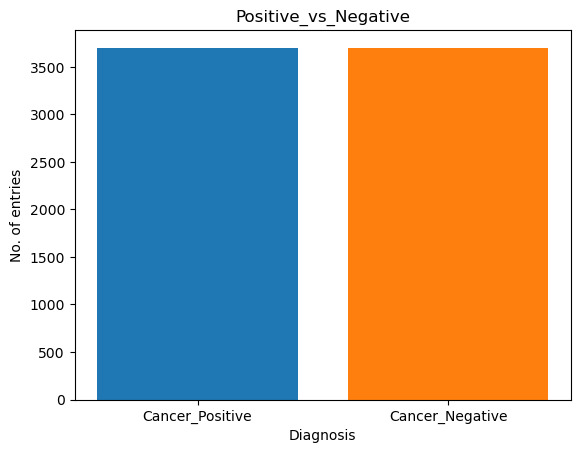

In [130]:
#plot of data
cancer_positive = len(cancer_train[cancer_train['cancer_negative'] == 0].index)
cancer_negative = len(cancer_train[cancer_train['cancer_negative'] == 1].index)
  
plt.bar('Cancer_Positive' ,cancer_positive, label= 'Positive')
plt.bar('Cancer_Negative' ,cancer_negative, label = 'Negative')
plt.xlabel("Diagnosis")
plt.ylabel("No. of entries")
plt.title("Positive_vs_Negative")
plt.show()

In [131]:
#add pathing to front of images in csv (chest_xrays/)
cancer_train['id'] = 'chest_xrays/' + cancer_train['id'].astype(str)
cancer_val['id'] = 'chest_xrays/' + cancer_val['id'].astype(str)
cancer_test['id'] = 'chest_xrays/' + cancer_test['id'].astype(str)

In [133]:
#adding entries from train to validation due to lack of entries
#adjust values
val_add = cancer_train[7000:7402]
cancer_train = cancer_train[0:7000]
cancer_val = cancer_val.append(val_add)
display(cancer_train)
display(cancer_val)

,id,cancer_negative,cancer_positive
3693,chest_xrays/00001697_009.png,1,0
43359,chest_xrays/00017375_002.png,0,1
44353,chest_xrays/00017795_000.png,0,1
3045,chest_xrays/00001402_000.png,1,0
7341,chest_xrays/00003101_003.png,0,1
...,...,...,...
1290,chest_xrays/00000626_000.png,1,0
39882,chest_xrays/00015852_007.png,0,1
1057,chest_xrays/00000514_006.png,1,0
3863,chest_xrays/00001761_002.png,1,0


,id,cancer_negative,cancer_positive
135,chest_xrays/00004532_000.png,0,1
144,chest_xrays/00018101_000.png,0,1
296,chest_xrays/00029025_002.png,1,0
298,chest_xrays/00029025_004.png,1,0
145,chest_xrays/00018101_006.png,0,1
...,...,...,...
4061,chest_xrays/00001836_086.png,1,0
20327,chest_xrays/00008362_008.png,0,1
214,chest_xrays/00000137_001.png,1,0
65049,chest_xrays/00028923_000.png,0,1


In [134]:
columns = ['cancer_negative', 'cancer_positive'] 

In [135]:
#preprocessing and splitting of train and test data
Train_Generator = ImageDataGenerator(rescale=1./255,
                                    shear_range=0.3,
                                    zoom_range=0.2,
                                    brightness_range=[0.2,0.9],
                                    rotation_range=30,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode="nearest",
                                    validation_split=0.1)

In [136]:
#preprocessing of training images
Train_IMG_Set = Train_Generator.flow_from_dataframe(dataframe=cancer_train,
                                                   x_col="id",
                                                   y_col=columns, #can add more categories here
                                                   color_mode="rgb",
                                                   class_mode="raw",
                                                   batch_size=50,
                                                   subset="training")

Found 4428 validated image filenames.


In [137]:
Validation_Generator = ImageDataGenerator(rescale=1./255,
                                    shear_range=0.3,
                                    zoom_range=0.2,
                                    brightness_range=[0.2,0.9],
                                    rotation_range=30,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode="nearest",
                                    validation_split=0.1)

In [138]:
#preprocessing of validation images
Validation_IMG_Set = Validation_Generator.flow_from_dataframe(dataframe=cancer_val,
                                                   x_col="id",
                                                   y_col=columns,
                                                   color_mode="rgb",
                                                   class_mode="raw",
                                                   batch_size=100,
                                                   subset="validation")

Found 33 validated image filenames.


In [139]:
Test_Generator = ImageDataGenerator(rescale=1./255)

In [140]:
#preprocessing of testing images
Test_IMG_Set = Test_Generator.flow_from_dataframe(dataframe=cancer_test,
                                                 x_col="id",
                                                 y_col=columns,
                                                 color_mode="rgb",
                                                 class_mode="raw",
                                                 batch_size=100)

Found 1234 validated image filenames.


In [141]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [143]:
model = Sequential()
model.add(Conv2D(input_shape=(256,256,3), filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=2, activation="softmax"))

In [144]:
from keras.optimizers import Adam
opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [145]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 128, 128, 128)     147584    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 64, 64, 256)      

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')
hist = model.fit_generator(steps_per_epoch=100,generator=Train_IMG_Set, validation_data= Validation_IMG_Set, validation_steps=10,epochs=20,callbacks=[checkpoint,early])

Epoch 1/20
  6/100 [>.............................] - ETA: 22:31 - loss: 1.0218 - accuracy: 0.6033

In [22]:
model.save('vgg16.h5')

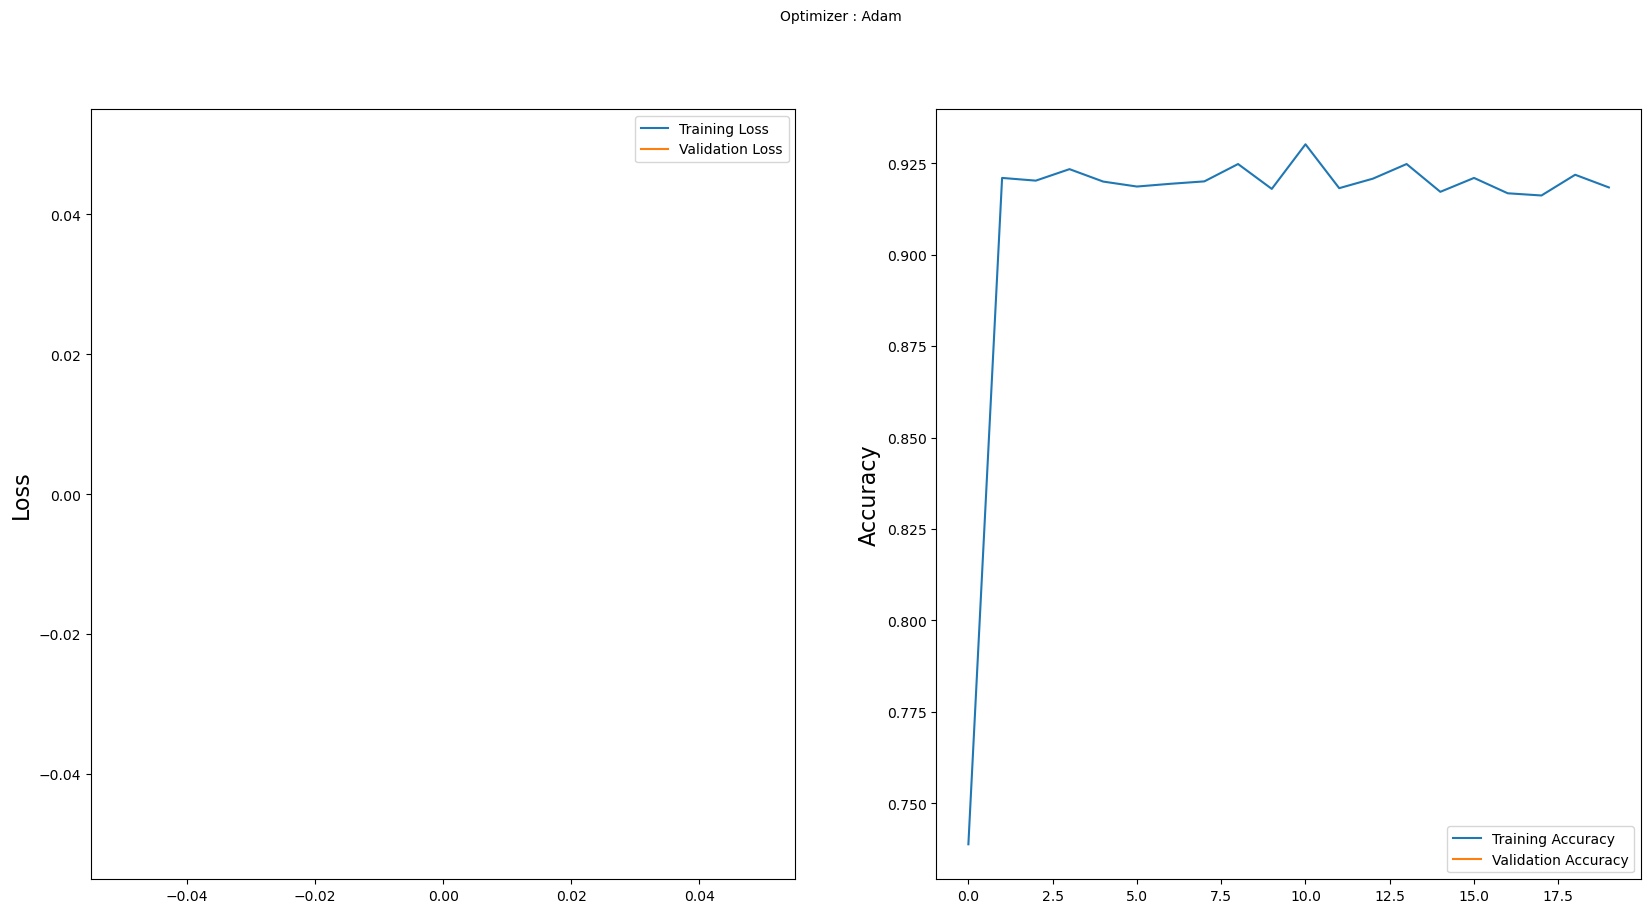

In [23]:
#plotting accuracy and loss
plt.style.use('default')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [25]:
#testing results
results = model.evaluate(Test_IMG_Set)
preds   = model.predict(Test_IMG_Set)
print('The current model achieved a categorical accuracy of {}%!'.format(round(results[1]*100,2)))

129/129 [==============================] - 1015s 8s/step - loss: nan - accuracy: 0.9296
The current model achieved a categorical accuracy of 92.96%!


In [28]:
#storing test predictions
Prediction_One = model.predict(Test_IMG_Set)
Prediction_One = Prediction_One.argmax(axis=-1)
Predict_Class = model.predict_classes(Test_IMG_Set)

In [72]:
import math

In [73]:
test_batches = Test_Generator.flow_from_dataframe(dataframe = cancer_test, x_col="id", y_col="cancer_positive", class_mode="raw", batch_size=100)
number_of_examples = len(Test_IMG_Set.filenames)
number_of_generator_calls = math.ceil(number_of_examples / (1.0 * 100)) 
# 1.0 above is to skip integer division

For_Prediction_Class = []

for i in range(0,int(number_of_generator_calls)):
    For_Prediction_Class.extend(np.array(test_batches[i][1]))

Found 12847 validated image filenames.


In [74]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve

In [75]:
#confusion matrix and other metrics
print(confusion_matrix(For_Prediction_Class,Predict_Class))
print(classification_report(For_Prediction_Class,Predict_Class))

[[11943     0]
 [  904     0]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     11943
           1       0.00      0.00      0.00       904

    accuracy                           0.93     12847
   macro avg       0.46      0.50      0.48     12847
weighted avg       0.86      0.93      0.90     12847



In [77]:
#validation
results_val = model.evaluate(Validation_IMG_Set)
preds_val   = model.predict(Validation_IMG_Set)
print('The current model achieved a categorical accuracy of {}%!'.format(round(results_val[1]*100,2)))

8/8 [==============================] - 45s 6s/step - loss: nan - accuracy: 0.8738
The current model achieved a categorical accuracy of 87.38%!


In [ ]:
#call saved model
#using an input run it on saved model
#model can predict cancerous or no cancerous
#same bounding boxes